## Part 1: Training a CNN from Scratch

Use the CIFAR-10 dataset, consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class, and train a CNN from scratch

### Load the necessary libraries

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Define transformation and load datasets

In [65]:
transform = transforms.Compose([ # no need to resize. original size is 32 x 32 pixel
    transforms.ToTensor(),
    # Simple normalization around mean=0.5, std=0.5
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Check datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Check classes in dataset
print(f"Classes in dataset: {train_dataset.classes}")

Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 50000
Test dataset size: 10000
Classes in dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Split train set into train and validation sets

In [13]:
# Split training into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for batching and shuffling the dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Define architecture of model then proceed to initialise model, loss function and optimiser

In [14]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        '''Implement the CNN architecture'''
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,padding=1) # input channel 3 for RGB. then gives output (32, 32, 32) --> pooling (32, 16, 16)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # --> input channel corresponds to output from conv1 to output (64, 16, 16) then undergoes pooling (64, 8, 8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64 * 8 * 8, 128) 
        self.fc2 = nn.Linear(128, 10) # 10 output classes
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.3) 
        
    def forward(self, x):
       '''Implement the forward pass'''
       x = self.pool(self.relu(self.conv1(x))) 
       x = self.pool(self.relu(self.conv2(x))) 
       x = x.view(x.size(0), -1) 
       x = self.relu(self.fc1(x))
       x = self.dropout(x)
       x = self.fc2(x)
       return x

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss() # for multi class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train and validate model

Epoch 1, Loss: 0.8115, Acc: 0.7099
Validation Acc: 0.6942
Epoch 2, Loss: 0.7438, Acc: 0.7379
Validation Acc: 0.7135
Epoch 3, Loss: 0.6875, Acc: 0.7569
Validation Acc: 0.7173
Epoch 4, Loss: 0.6373, Acc: 0.7722
Validation Acc: 0.7146
Epoch 5, Loss: 0.5905, Acc: 0.7882
Validation Acc: 0.7145
Epoch 6, Loss: 0.5482, Acc: 0.8020
Validation Acc: 0.7159
Epoch 7, Loss: 0.5105, Acc: 0.8144
Validation Acc: 0.7238
Epoch 8, Loss: 0.4703, Acc: 0.8289
Validation Acc: 0.7142
Epoch 9, Loss: 0.4471, Acc: 0.8368
Validation Acc: 0.7225
Epoch 10, Loss: 0.4142, Acc: 0.8467
Validation Acc: 0.7115


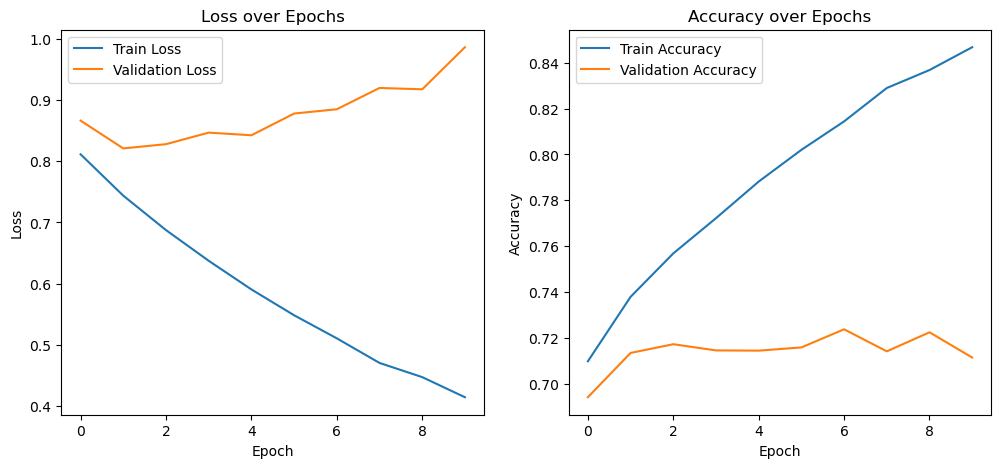

In [22]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  # Track loss across batches
        running_correct, total_samples = 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute average loss across each batch
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item() * images.size(0)  # Accumulate loss
            _, pred = torch.max(outputs, 1) # get predicted class by computing the max value along the cols for each row. the output of torch.max is values, indices where values corresp to highest logit, and indices correspond to the class
            running_correct += (pred == labels).sum().item()  # Accumulate correct predictions
            total_samples += labels.size(0)  # Accumulate total samples
        
        # Epoch level metrics
        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)
                _, val_pred = torch.max(val_outputs, 1) # get predicted class as above
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)
        
        # Validation metrics
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Model testing

In [24]:
def test(model, test_loader, criterion):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_outputs = model(test_images)
            #test_loss += criterion(test_outputs, test_labels).item() * test_images.size(0)
            _, test_preds = (torch.max(test_outputs, 1))

            test_correct += (test_preds == test_labels).sum().item()
            test_total += test_labels.size(0)

    test_acc = test_correct / test_total
    print(f"Final Test Accuracy: {test_acc*100:.4f}%")
    return test_acc

test_acc = test(model, test_loader, criterion)

Final Test Accuracy: 71.1300%


### Visualise predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


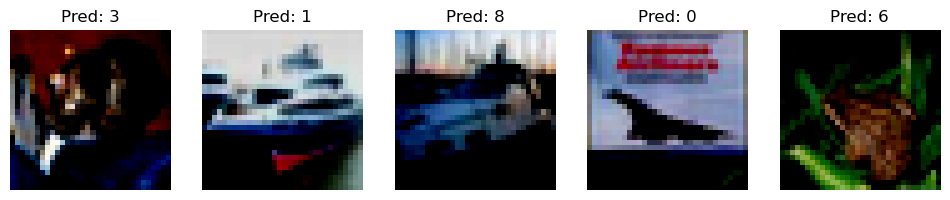

In [39]:
# Visualize Predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images], labels[:num_images]  # Take first few images

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()

    # Plot images with predicted labels
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img = np.transpose(images[i], (1, 2, 0))  # Convert to HWC format
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {predicted[i].item()}", fontsize=12)
        axes[i].axis("off")
    plt.show()

visualize_predictions(model, test_loader)

## Part 2: Transfer learning

Load pre-trained model (ResNet-18) on CIFAR-10 dataset for performance comparison with CNN trained from scratch

In [47]:
import torchvision.models as models

# Load ResNet-18 pre-trained model
res_model = models.resnet18(pretrained=True)

# View model architecture
print(res_model)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Re-load dataset with the appropriate normalisation values
#### Experiment 1: Unfreeze only fully connected layer in ResNet model for model training

In [59]:
# Change resnet output parameters to match CIFAR-10 dataset
res_model.fc = nn.Linear(res_model.fc.in_features, 10) # change from 1000 output to 10

# Freeze all layers first
for param in res_model.parameters():
    param.requires_grad = False

# Then unfreeze the fully connected (fc) layer
for param in res_model.fc.parameters():
    param.requires_grad = True  # Unfreeze the fc layer

# Define transformation for CIFAR loaded on resnet
transform_res = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalisation values
])

# Reload CIFAR-10 dataset with normalisation
res_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_res)
res_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_res)
res_train, res_val = random_split(res_train, [train_size, val_size])

# Create dataloaders
res_train_loader = DataLoader(res_train, batch_size=64, shuffle=True)
res_val_loader = DataLoader(res_val, batch_size=64, shuffle=False)
res_test_loader = DataLoader(res_test, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
# Verify Updated Fully Connected Layer
print("After Modification:", res_model.fc)

After Modification: Linear(in_features=512, out_features=10, bias=True)


### Initialise loss function and optimiser to run pre-loaded model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_model.fc.parameters(), lr=0.001) # tune just the final layer that had changes to output no

### Train model and evaluate performance

Epoch 1, Loss: 1.7496, Acc: 0.3870
Validation Acc: 0.4429
Epoch 2, Loss: 1.6073, Acc: 0.4389
Validation Acc: 0.4668
Epoch 3, Loss: 1.5845, Acc: 0.4456
Validation Acc: 0.4575
Epoch 4, Loss: 1.5767, Acc: 0.4457
Validation Acc: 0.4650
Epoch 5, Loss: 1.5601, Acc: 0.4561
Validation Acc: 0.4591
Epoch 6, Loss: 1.5625, Acc: 0.4537
Validation Acc: 0.4672
Epoch 7, Loss: 1.5573, Acc: 0.4551
Validation Acc: 0.4685
Epoch 8, Loss: 1.5611, Acc: 0.4545
Validation Acc: 0.4688
Epoch 9, Loss: 1.5571, Acc: 0.4565
Validation Acc: 0.4726
Epoch 10, Loss: 1.5589, Acc: 0.4552
Validation Acc: 0.4661


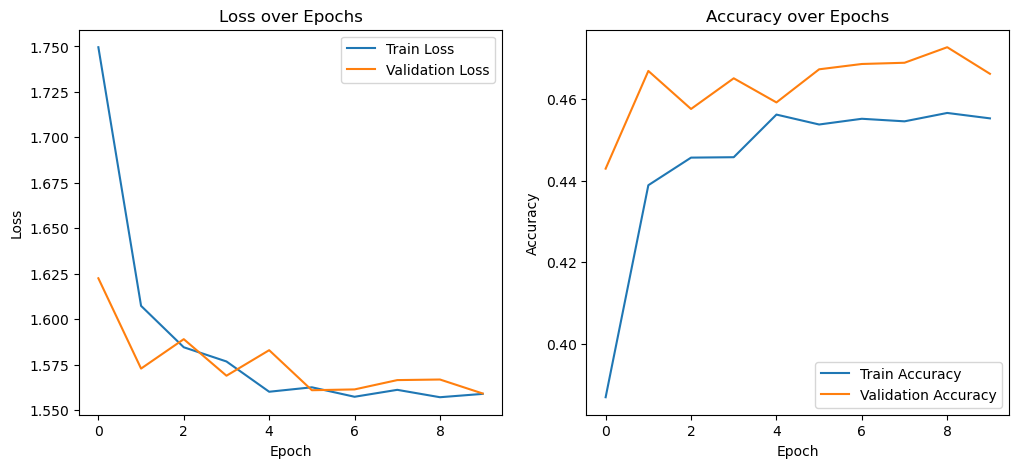

Model Accuracy: 45.33%


In [63]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  # Track loss across batches
        running_correct, total_samples = 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute average loss across each batch
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item() * images.size(0)  # Accumulate loss
            _, pred = torch.max(outputs, 1) # get predicted class by computing the max value along the cols for each row. the output of torch.max is values, indices where values corresp to highest logit, and indices correspond to the class
            running_correct += (pred == labels).sum().item()  # Accumulate correct predictions
            total_samples += labels.size(0)  # Accumulate total samples
        
        # Epoch level metrics
        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)
                _, val_pred = torch.max(val_outputs, 1) # get predicted class as above
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)
        
        # Validation metrics
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

# Train the model
res_train_losses, res_val_losses, res_train_accuracies, res_val_accuracies = train(res_model, res_train_loader, res_val_loader, criterion, optimizer, epochs=10)

# Plot the metrics
plot_metrics(res_train_losses, res_val_losses, res_train_accuracies, res_val_accuracies)

# Test trained resnet 18 model on test set
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

accuracy = calculate_accuracy(res_model, res_test_loader)
print(f"Model Accuracy: {accuracy:.2f}%")

### Visualise predictions from ResNet-18 model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.8158263].


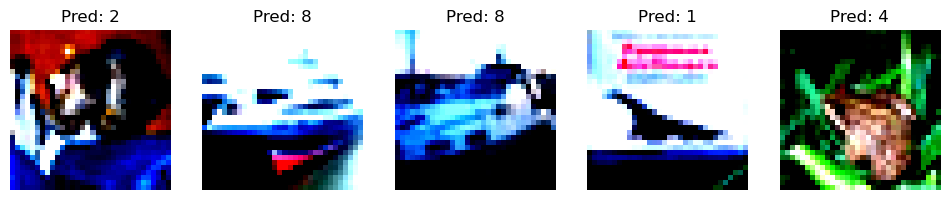

In [64]:
# Visualize Predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images], labels[:num_images]  # Take first few images

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()

    # Plot images with predicted labels
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img = np.transpose(images[i], (1, 2, 0))  # Convert to HWC format
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {predicted[i].item()}", fontsize=12)
        axes[i].axis("off")
    plt.show()

visualize_predictions(res_model, res_test_loader)

### Experiment 2: Unfreeze layers 3, 4 and fc 
Rationale: Deeper layers focus on more task-specific representations. Since CIFAR-10 is largely different from ImageNet, final few layers would be preferred to adapt the model to this new dataset, while leaving early layers to retain general feature-extraction.

Epoch 1, Loss: 0.8125, Acc: 0.7249
Validation Acc: 0.7739
Epoch 2, Loss: 0.5851, Acc: 0.7997
Validation Acc: 0.7844
Epoch 3, Loss: 0.4458, Acc: 0.8470
Validation Acc: 0.7895
Epoch 4, Loss: 0.3261, Acc: 0.8878
Validation Acc: 0.8029
Epoch 5, Loss: 0.2581, Acc: 0.9102
Validation Acc: 0.7919
Epoch 6, Loss: 0.1863, Acc: 0.9352
Validation Acc: 0.7979
Epoch 7, Loss: 0.1444, Acc: 0.9492
Validation Acc: 0.7997
Epoch 8, Loss: 0.1109, Acc: 0.9626
Validation Acc: 0.7971
Epoch 9, Loss: 0.0994, Acc: 0.9659
Validation Acc: 0.7962
Epoch 10, Loss: 0.0925, Acc: 0.9676
Validation Acc: 0.7951


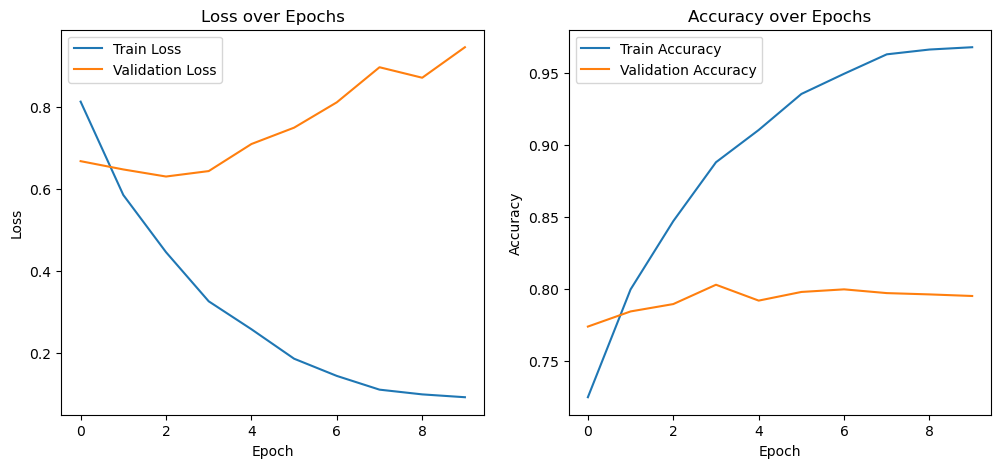

Model Accuracy with layers 3, 4 and fc of ResNet-18 unfrozen: 78.48%


In [70]:
# Unfreeze layer3, layer4 and fc for gradient 
for name, param in res_model.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False # keeps early layers frozen

# Adjust optimiser to include newly frozen layers
params_update = [param for param in res_model.parameters() if param.requires_grad]
optimizer = optim.Adam(params_update, lr=0.001)

# Train the model again
res_train_losses, res_val_losses, res_train_accuracies, res_val_accuracies = train(res_model, res_train_loader, res_val_loader, criterion, optimizer, epochs=10)

# Plot the metrics again
plot_metrics(res_train_losses, res_val_losses, res_train_accuracies, res_val_accuracies)

# Calculate accuracy again
accuracy = calculate_accuracy(res_model, res_test_loader)
print(f"Model Accuracy with layers 3, 4 and fc of ResNet-18 unfrozen: {accuracy:.2f}%")

## Part 3: Performance Comparison & Analysis

Final test accuracy of CNN trained from scratch: 71.13% 

Final test accuracy of ResNet-18 model with fc unfrozen: 45.33%

Final test accuracy of ResNet-18 model with layers 3, 4 and fc unfrozen: 78.48%